# Predict MVP 2022 TEST


In [1]:
import pickle
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import commonallplayers #per avere l'elenco dei giocatori (id)
from nba_api.stats.endpoints import playercareerstats #per avere i dati
from nba_api.stats.endpoints import playerawards #per sapere chi ha vinto MVP
from nba_api.stats.endpoints import teamyearbyyearstats #classifiche finali delle squadre
import pandas as pd
from tqdm import tqdm
import pickle

## Scarico i giocatori 2022

In [2]:
from_year = 2021

total_players = commonallplayers.CommonAllPlayers().get_data_frames()[0]
total_players['TO_YEAR'] = total_players['TO_YEAR'].astype('int')
total_players = total_players[total_players['TO_YEAR'] == from_year]

#Ho controllato che in total_players, il PERSON_ID sia univoco
total_players

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,PLAYER_SLUG,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,TEAM_SLUG,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH
10,1630173,"Achiuwa, Precious",Precious Achiuwa,1,2020,2021,precious_achiuwa,precious_achiuwa,1610612761,Toronto,Raptors,TOR,raptors,raptors,Y,00
22,203500,"Adams, Steven",Steven Adams,1,2013,2021,steven_adams,steven_adams,1610612763,Memphis,Grizzlies,MEM,grizzlies,grizzlies,Y,00
24,1628389,"Adebayo, Bam",Bam Adebayo,1,2017,2021,bam_adebayo,bam_adebayo,1610612748,Miami,Heat,MIA,heat,heat,Y,00
40,1630583,"Aldama, Santi",Santi Aldama,1,2021,2021,santi_aldama,santi_aldama,1610612763,Memphis,Grizzlies,MEM,grizzlies,grizzlies,Y,00
43,200746,"Aldridge, LaMarcus",LaMarcus Aldridge,1,2006,2021,lamarcus_aldridge,lamarcus_aldridge,1610612751,Brooklyn,Nets,BKN,nets,nets,Y,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,201152,"Young, Thaddeus",Thaddeus Young,1,2007,2021,thaddeus_young,thaddeus_young,1610612759,San Antonio,Spurs,SAS,spurs,spurs,Y,00
4703,1629027,"Young, Trae",Trae Young,1,2018,2021,trae_young,trae_young,1610612737,Atlanta,Hawks,ATL,hawks,hawks,Y,00
4704,1630209,"Yurtseven, Omer",Omer Yurtseven,1,2020,2021,tmp_omer_yurtseven,omer_yurtseven,1610612748,Miami,Heat,MIA,heat,heat,Y,01
4707,203469,"Zeller, Cody",Cody Zeller,1,2013,2021,cody_zeller,cody_zeller,1610612757,Portland,Trail Blazers,POR,blazers,blazers,Y,00


In [3]:
all_teams_history = list(total_players["TEAM_ID"].drop_duplicates())
data_all_team_stats = pd.DataFrame()

for team in all_teams_history:
    t = teamyearbyyearstats.TeamYearByYearStats(team_id=team).get_data_frames()[0]
    #t["SEASON_ID"] = t[t["SEASON_ID"] == "2021-22"] # Non cambia tanto perchè nel get prende tutti
    data_all_team_stats = pd.concat([data_all_team_stats, t], axis=0, ignore_index=True)

data_all_team_stats = data_all_team_stats.rename(columns={"YEAR": "SEASON_ID"})
data_all_team_stats = data_all_team_stats[["TEAM_ID", "SEASON_ID", "CONF_RANK"]]

with open("data_all_team_stats_2022.pkl",'wb') as f:
    pickle.dump(data_all_team_stats,f)

data_all_team_stats

,TEAM_ID,SEASON_ID,CONF_RANK
0,1610612761,1995-96,14
1,1610612761,1996-97,12
2,1610612761,1997-98,15
3,1610612761,1998-99,10
4,1610612761,1999-00,6
...,...,...,...
1562,1610612742,2017-18,13
1563,1610612742,2018-19,14
1564,1610612742,2019-20,7
1565,1610612742,2020-21,5


In [4]:
total_names = total_players[["PERSON_ID", "DISPLAY_FIRST_LAST"]]
total_stats = pd.DataFrame()
with open("data_all_team_stats_2022.pkl", "rb") as f:
    data_all_team_stats = pickle.load(f)

for index, row in tqdm(total_names.iterrows()):
    stats = playercareerstats.PlayerCareerStats(player_id=row["PERSON_ID"]).get_data_frames()[0]

    stats = stats.drop(stats.columns[[2, 4, 7]], axis=1)

    awards = playerawards.PlayerAwards(player_id=row["PERSON_ID"]).get_data_frames()[0]

    awards = awards.drop(awards.columns[[0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13]], axis=1) #Tolgo anche PERSON_ID
    awards = awards.rename(columns={"SEASON": "SEASON_ID"})
    awards = awards.loc[awards["DESCRIPTION"]=="NBA Most Valuable Player"]

    #merge
    stats=stats.merge(awards, how="left", on="SEASON_ID")
    #1 to MVP, 0 to other
    stats["DESCRIPTION"] = stats["DESCRIPTION"].replace("NBA Most Valuable Player", 1) #Replace the description MVP with 1
    stats["DESCRIPTION"] = stats["DESCRIPTION"].fillna(0) #Replace NULL with 0
    stats = stats.rename(columns={"DESCRIPTION": "MVP"})

    #merge della classifica in cui è arrivata la squadra in una certa stagione
    stats = stats.merge(data_all_team_stats, how="inner", on=["SEASON_ID", "TEAM_ID"])

    total_stats = pd.concat([total_stats, stats],axis=0,ignore_index=True)


#Tolgo la formattazione "year1-year2" (2010-11) e lascio solo il secondo anno (2011)
total_stats["SEASON_ID"] = [int("20"+x.split("-")[1]) for x in list(total_stats["SEASON_ID"])] #Problema se si prendono dati < anno 2000
#Prendo i dati superiore all'anno FROM_YEAR
total_stats= total_stats[total_stats["SEASON_ID"] > from_year]


with open("player_stats_2022.pkl",'wb') as f:
    pickle.dump(total_stats,f)

608it [25:50,  2.55s/it]


## Predizione 2022, preparo i dati appena scaricati

In [6]:
with open("player_stats_2022.pkl", "rb") as f:
    season_2021 = pickle.load(f)
#tolgo seasons che non ci servono
season_2021 = season_2021[season_2021["SEASON_ID"] == 2022]


#sposto la colonna MVP per prima per comodita
cols = season_2021.columns.tolist()
cols = cols[-2:] + cols[:-2]
season_2021 = season_2021[cols]

season_2021["GP"]=season_2021["GP"].astype('int')
season_2021["FGM"]=season_2021["FGM"].astype('int')
season_2021["FGA"]=season_2021["FGA"].astype('int')
season_2021["FG3M"]=season_2021["FG3M"].astype('int')
season_2021["FG3A"]=season_2021["FG3A"].astype('int')
season_2021["FTM"]=season_2021["FTM"].astype('int')
season_2021["FTA"]=season_2021["FTA"].astype('int')
season_2021["OREB"]=season_2021["OREB"].astype('int')
season_2021["DREB"]=season_2021["DREB"].astype('int')
season_2021["REB"]=season_2021["REB"].astype('int')
season_2021["AST"]=season_2021["AST"].astype('int')
season_2021["STL"]=season_2021["STL"].astype('int')
season_2021["BLK"]=season_2021["BLK"].astype('int')
season_2021["TOV"]=season_2021["TOV"].astype('int')
season_2021["PF"]=season_2021["PF"].astype('int')
season_2021["PTS"]=season_2021["PTS"].astype('int')


season_2021

,MVP,CONF_RANK,PLAYER_ID,SEASON_ID,TEAM_ID,PLAYER_AGE,GP,MIN,FGM,FGA,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
1,0.0,8,1630173,2022,1610612761,22.0,31,772.0,104,254,...,0.569,73,163,236,42,19,21,34,72,246
10,0.0,3,203500,2022,1610612763,28.0,41,1046.0,108,202,...,0.600,176,205,381,122,35,25,65,69,285
15,0.0,3,1628389,2022,1610612748,24.0,18,592.0,126,243,...,0.759,49,134,183,57,20,6,53,59,337
16,0.0,3,1630583,2022,1610612763,21.0,23,245.0,32,86,...,0.579,22,38,60,13,2,6,8,23,79
33,0.0,2,200746,2022,1610612751,36.0,29,663.0,165,292,...,0.846,43,120,163,23,11,32,25,48,386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,0.0,12,201152,2022,1610612759,33.0,23,323.0,65,114,...,0.444,34,45,79,55,20,6,23,33,138
3333,0.0,12,1629027,2022,1610612737,23.0,38,1314.0,359,791,...,0.898,27,123,150,354,37,4,156,64,1049
3334,0.0,3,1630209,2022,1610612748,23.0,34,538.0,96,186,...,0.640,65,164,229,41,15,18,33,64,225
3343,0.0,10,203469,2022,1610612757,29.0,27,355.0,51,90,...,0.776,50,75,125,22,8,6,19,56,140


In [7]:
#standardizzazione i nostri dati per anno

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

num_cols = season_2021.columns
num_cols = num_cols.drop(["MVP",'CONF_RANK', 'PLAYER_ID', 'SEASON_ID', 'TEAM_ID'])

season_2021_norm=pd.DataFrame()
season_2021_norm = pd.concat([season_2021_norm, season_2021],axis=0,ignore_index=True)


In [8]:

for col in num_cols.tolist():
    season_2021_norm[[col]] = scaler.fit_transform(season_2021[[col]].to_numpy().reshape(-1,1))

season_2021_norm

,MVP,CONF_RANK,PLAYER_ID,SEASON_ID,TEAM_ID,PLAYER_AGE,GP,MIN,FGM,FGA,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,0.0,8,1630173,2022,1610612761,-0.914562,0.604307,0.604807,0.234068,0.364835,...,-0.211331,1.945856,1.207153,1.456797,-0.121993,0.181823,0.796619,0.196904,0.921963,0.082193
1,0.0,3,203500,2022,1610612763,0.533070,1.308133,1.220566,0.279285,0.094829,...,-0.110186,5.841128,1.764042,2.939203,1.092762,1.164307,1.090154,1.173040,0.834956,0.242483
2,0.0,3,1628389,2022,1610612748,-0.432018,-0.310666,0.200294,0.482762,0.307719,...,0.408589,1.038219,0.822634,0.914952,0.105773,0.243229,-0.304137,0.795181,0.544929,0.456203
3,0.0,3,1630583,2022,1610612763,-1.155833,0.041247,-0.579518,-0.579839,-0.507492,...,-0.178704,0.017129,-0.450255,-0.342537,-0.562342,-0.862066,-0.304137,-0.621791,-0.499165,-0.604176
4,0.0,2,200746,2022,1610612751,2.463245,0.463542,0.359852,0.923628,0.562148,...,0.692448,0.811310,0.637004,0.710483,-0.410498,-0.309419,1.603840,-0.086490,0.225900,0.657592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,0.0,12,201152,2022,1610612759,1.739430,0.041247,-0.404229,-0.206798,-0.362104,...,-0.619174,0.470947,-0.357440,-0.148290,0.075405,0.243229,-0.304137,-0.149467,-0.209139,-0.361686
612,0.0,12,1629027,2022,1610612737,-0.673290,1.096985,1.822841,3.116656,3.153168,...,0.862111,0.206220,0.676782,0.577577,4.615552,1.287118,-0.450905,4.038471,0.689942,3.382518
613,0.0,3,1630209,2022,1610612748,-0.673290,0.815455,0.078940,0.143634,0.011750,...,0.020323,1.643310,1.220412,1.385233,-0.137178,-0.063798,0.576467,0.165416,0.689942,-0.004117
614,0.0,10,203469,2022,1610612757,0.774342,0.322777,-0.332315,-0.365058,-0.486723,...,0.464056,1.076038,0.040337,0.321990,-0.425682,-0.493634,-0.304137,-0.275420,0.457921,-0.353466


## Predict 2021

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
test_2021_labels = season_2021_norm[["MVP"]]

name_model = "log_reg"

# with open("svm_40.pkl", "rb") as f:
with open(name_model+".pkl", "rb") as f:
# with open("svm.pkl", "rb") as f:
# with open("rf.pkl", "rb") as f:
# with open("log_reg.pkl", "rb") as f:

    log_reg = pickle.load(f)


    ###                             ###

# train_2021 = season_2021_norm[["CONF_RANK", "GP", "MIN", "FGM", "FG_PCT", "FG3M", "FG3_PCT", "FTM", "FT_PCT", "OREB", "DREB", "AST", "STL", "BLK", "TOV", "PF"]]
train_2021 = season_2021_norm[["CONF_RANK", "GP", "MIN", "FG_PCT", "FG3M", "FG3_PCT", "FTM", "FT_PCT", "OREB", "DREB", "AST", "STL", "BLK", "PF"]]
# train_2021 = season_2021_norm.drop(["MVP", 'PLAYER_ID', 'SEASON_ID', 'TEAM_ID', "PLAYER_AGE"], axis=1)


predicted_labels = log_reg.predict(train_2021)
print(f"The balanced accuracy score is  {balanced_accuracy_score(test_2021_labels,predicted_labels)}")

The balanced accuracy score is  0.9951298701298701


/home/thomas/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [24]:
#Unisco i dataset
predict_2021 = pd.DataFrame(predicted_labels, columns=["MVP_Predict"])
predict_2021["PLAYER_ID"] = list(season_2021["PLAYER_ID"])

winners_id = predict_2021.loc[predict_2021["MVP_Predict"] == 1, "PLAYER_ID"]

In [25]:
from nba_api.stats.static import players

for id in list(winners_id):
    print(players.find_player_by_id(id))

{'id': 201142, 'full_name': 'Kevin Durant', 'first_name': 'Kevin', 'last_name': 'Durant', 'is_active': True}
{'id': 201935, 'full_name': 'James Harden', 'first_name': 'James', 'last_name': 'Harden', 'is_active': True}
{'id': 101108, 'full_name': 'Chris Paul', 'first_name': 'Chris', 'last_name': 'Paul', 'is_active': True}


### PROBABILITIES 2021

In [26]:

# test_2021_labels = season_2021_norm[["MVP"]]
#
# with open("log_reg.pkl", "rb") as f:
#     log_reg = pickle.load(f)

#train_2021 = season_2021_norm[["GP", "MIN", "FGM", "FG_PCT", "FG3M", "FG3_PCT", "FTM", "FT_PCT", "OREB", "DREB", "AST", "STL", "BLK", "TOV", "PF", 'CONF_RANK']]
predicted_labels = pd.DataFrame(log_reg.predict_proba(train_2021))

predicted_labels.rename(columns={0:'NOT',1:'MVP'},inplace=True)

predicted_labels = pd.DataFrame(predicted_labels, columns=["MVP"])
predicted_labels["PLAYER_ID"] = list(season_2021["PLAYER_ID"])

#Sort
mvp_candidates = predicted_labels.sort_values(by='MVP',ascending=False)

#Take only better
mvp_candidates = mvp_candidates.head(10)

mvp_candidates_names = pd.DataFrame()
# for row, id in mvp_candidates["PLAYER_ID"].iterrows():
#     name_player = players.find_player_by_id(id["PLAYER_ID"])
#     if name_player is not None:
#         name = pd.DataFrame.from_dict(name_player, orient="index")
#
#         name = name.transpose()
#         name["mvp_prob"] = list(id["MVP"])
#         mvp_candidates_names = pd.concat([mvp_candidates_names,name], axis=0, ignore_index=True)

for id in list(mvp_candidates["PLAYER_ID"]):
    name_player = players.find_player_by_id(id)
    name = pd.DataFrame.from_dict(name_player, orient="index")

    name = name.transpose()
    mvp_candidates_names = pd.concat([mvp_candidates_names,name], axis=0, ignore_index=True)

mvp_candidates_names["mvp_prob"] = list(mvp_candidates["MVP"])
mvp_candidates_names

,id,full_name,first_name,last_name,is_active,mvp_prob
0,201935,James Harden,James,Harden,True,0.996156
1,101108,Chris Paul,Chris,Paul,True,0.862613
2,201142,Kevin Durant,Kevin,Durant,True,0.739993
3,201942,DeMar DeRozan,DeMar,DeRozan,True,0.271939
4,201939,Stephen Curry,Stephen,Curry,True,0.118169
5,203897,Zach LaVine,Zach,LaVine,True,0.109804
6,203507,Giannis Antetokounmpo,Giannis,Antetokounmpo,True,0.028612
7,1629630,Ja Morant,Ja,Morant,True,0.015830
8,1626164,Devin Booker,Devin,Booker,True,0.004846
9,202696,Nikola Vucevic,Nikola,Vucevic,True,0.003292


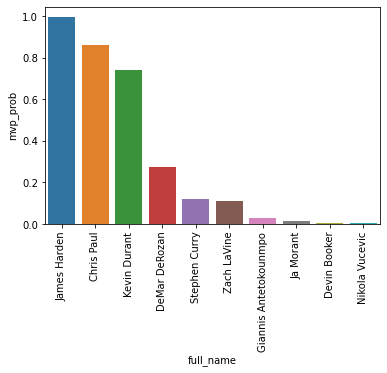

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
#mvp_candidates_names.plot.bar(x='full_name',y='mvp_prob' )
sns.barplot(x='full_name',y='mvp_prob',data=mvp_candidates_names.head(10))
plt.xticks(rotation=90)
plt.savefig('plot/'+name_model+'_2022.png', bbox_inches='tight')

In [82]:
real_winners_2021 = ["NIKOLA JOKIC", "JOEL EMBIID", "STEPHEN CURRY", "GIANNIS ANTETOKOUNMPO", "CHRIS PAUL", "LUKA DONCIC", "DAMIAN LILLARD", "JULIUS RANDLE", "DERRICK ROSE", "RUDY GOBERT"]

real_winners_2021 = [str.title() for str in real_winners_2021] #Title for capitalize name and surname

versus = pd.DataFrame()
versus["Predicted_rank"] = list(mvp_candidates_names["full_name"].head(10))
versus["Real_rank"] = real_winners_2021
weight = list(reversed(range(1,11)))
i = 0
score = 0

# for row, names in versus.iterrows():
#     if names["Predicted_rank"] == names["Real_rank"]:
#         score = score + weight[i]
#     else:
#         j = i + 1
#         real_name = names["Real_rank"]
#         while names["Predicted_rank"] != real_name or j < 9:
#             real_name = versus.at[j,"Real_rank"]
#             j = j + 1
#
#         if j > 10:
#             score = score + weight[j]
#
#     i = i+1

for row, names in versus.iterrows():
    if names["Predicted_rank"] == names["Real_rank"]:
        score = score + weight[0]

score = score / sum(weight)
score



0.0